<span style="color:####; font-family: sabon; font-size: 3em;">
    <center> MNIST using Non-Negative Matrix Factorization </center> <br>
</span>

<span style="color:####; font-family: sabon; font-size: 2.5em;">
   <center> Machine Learning Algorithms </center> <br>
    <center> Kevin Emmanuel Soto Hernandez </center> <br>
</span>


**Ejercicio 1**. Considere la base de datos MNIST, la cual consiste en $70,000$ pares $(X, y)$, donde
$X$ es una imagen en escala de grises de tamaño $28 × 28$, la cual corresponde a un dígito escrito a
mano entre $0$ y $9$. Elija dos dígitos distintos entre $0$ y $9$ (a su gusto), y tome $1000$ imágenes del primer dígito, y $1000$ imágenes del segundo dígito.

Para realizar éste apartado, primero importamos todas las librerias necesarias. En donde ``from keras.datasets import mnist`` contiene la base de datos de las $70000$ imagenes de los dígitos.

In [1]:
from sklearn.decomposition import NMF
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


Descargamos la base de datos en las siguientes variables.

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

``X_train`` es un 3-D numpy array de dimensiones $(6000,28,28)$ con todas las imagenes de los digitos mezcladas, mientras que ``y_traint`` es un 1-D numpy array que contiene sus etiquetas respectivas. Podemos usar estos arreglos para muestrear $1000$ imágenes del dígito $0$ y $7$.

In [3]:
D0 = X_train[y_train==0]
D0 = D0[:1000]
D7 = X_train[y_train==7]
D7 = D7[:1000]

El tensor `D0` contiene $1000$ imagenes del digito $0$. 

El tensor `D7` contiene $1000$ imagenes del digito $7$.

Definimos una función que imprime en Notebook la imagen del dígito a tráves de su matriz de calor para comprobar que el indexado fue hecho de manera correcta.

In [370]:
def visualizar_imagen(matrix):
    '''
    Para visualizar en imagen el expectro de calor de una matriz
    
    Parámetros
    -----------
    matrix   :  2-D numpy array 
    
    Regresa
    ----------
    Imprime imagen de la matriz
    '''
    fig = plt.figure(figsize=(2.5,2.5))
    ax = fig.add_subplot(111)
    ax.imshow(matrix, origin="upper", interpolation="gaussian")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)

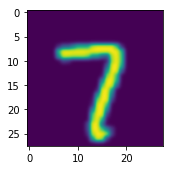

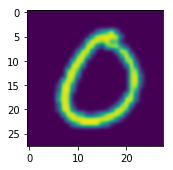

In [407]:
visualizar_imagen(D7[254])
visualizar_imagen(D0[254])

**Ejercicio 2.** Para cada una de las imágenes elegidas $X_i$, $1 \leq i \leq 2000$, transforme la imagen $X_i$ de tamaño
$28x28$ en un vector columna $a_i$ de tamaño $784x1$. Estas imágenes vectorizadas formarán las
columnas de la matriz $A \in \mathbb{R}^{784×2000}$. Observe que $A \geq 0$ (si no lo es, debe convertir previamente
el rango de las imágenes a un intervalo de valores no-negativos).

Definimos una función que toma como argumento un tensor de dimensión $(n,m,k)$ (la base de datos mnist está organizada en un 3-D array) y regresa un 2-D array de dimensión $(mk,n)$  en donde cada columna se compone de los sub arrays 2-D vectorizados. Es decir, los estira y despues los apila en una matriz.

In [54]:
def tensor_to_matrix(tensor):
    '''
    Transforma un tensor de n x m x k en una matriz m*k x n
    
    Parámetros
    -----------
    tensor  :  3-D numpy array de dimensión n x m x k
    
    Regresa
    -----------
    matrix  :  2-D numpy array de dimensión m*k x n
    '''
    n, m, k = tensor.shape
    matrix = np.reshape(tensor[0],(m*k,1))
    for i in range(1,n):
        xcol = np.reshape(tensor[i], (m*k,1))
        matrix = np.column_stack((matrix, xcol))
    return matrix

Ahora, concatenamos ambas bases de datos ``D1`` y ``D7`` en una sola ``A`` y despues la transformamos en una matriz de dimensión $(784,2000)$ donde cada columna de la matriz ``A`` se compone de la imagen del digito vectorizada. 

In [15]:
A = np.vstack([D0,D7])
A = tensor_to_matrix(A)

El problema consiste en calcular aproximaciones de la factoración no-negativa $A = WH$, con menos columnas para $W$, y menos renglones para $H$ que el rango $r = rank(A)$:

$$A = WH, \: con \: W \in \mathbb{R}^{nxr}, H \in \mathbb{R}^{rxm},\: y \: r < rank(A)$$

mediante la optimización de:

$$\min_{W,H \geq 0} \frac{1}{2} \lVert A -WH \rVert^2_F$$

**Ejercicio 3.** Implemente el método de gradiente proyectado, versión descafeinada, para resolver el problema de optimización implementando condiciones de paro apropiadas para detener el algoritmo. Puede utilizar cualquier esquema de descenso gradiente visto en aula dentro del método de gradiente proyectado (por ejemplo: GD simple, momentum, Nesterov, ...).
> *Sugerencia*. Revisar la optimización de RBF no-negativa con gradiente proyectado descafeinado vista en clase.

Todo optimizador necesita de una función objetivo; y como veremos en el siguiente ejercicio, el problema NMF (Non-negative Matrix Fatorization) es encontrar los elementos de la matriz $H$ ($h_{ij}$) y $W$ ($w_{ij}$) que minimizen la norma cuadrada de Frobenius definida como:

$$ f(w,h) = \frac{1}{2} \lVert A -WH \rVert^2_F = \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{m} [a_{ij} - (WH)_{ij}]^2 $$

$$con \: (WH)_{ij} = \sum_{k=1}^{r} w_{ik}h_{kj}$$

Implementar esta función en ``Python`` es relativamente sencillo. Basta con llamar a la función `numpy.linalg.norm(X)` y elevarla al cuadrado (se puede precindir del valor $1/2$).  

In [8]:
def f(X):
    '''Función objetivo.
    
     Parámetros
     -----------
     X  : 2-D numpy array
     
     Regresa
     -----------
     int - norma de Frobenius elevada al cuadrado
     '''
    return 0.5*np.linalg.norm(X)**2

Adémas, si deseamos implementar algún algoritmo del tipo *Descenso de Gradiente*, necesitamos justamente el gradiente de la función objetivo.
Con los elemento de $W$ fijos, derivamos la función con respecto al vector $h = [h_{11}, h_{12}, h_{13}, \dots, h_{rm}]$.

$$\nabla_h f(h) = \frac{1}{2} \nabla_h \sum_{i=1}^{n} \sum_{j=1}^{m} \left( a_{ij} - \sum_{k=1}^{r} w_{ik}h_{kj} \right)^2 $$

Para hacer esto más fácil, derivemos con respecto a un sola variable $h_{pq}$ en orden de entontrar el $pq$-ésimo elemento del gradiente.

$$\left( \nabla_h f \right)_{pq}  =  \frac{1}{2} \frac{\partial}{\partial h_{pq}} \sum_{i=1}^{n} \sum_{j=1}^{m} \left( a_{ij} - \sum_{k=1}^{r} w_{ik}h_{kj} \right)^2 $$

Observe que 

$$  \frac{\partial}{\partial h_{pq}}  \left( a_{ij} - \sum_{k=1}^{r} w_{ik}h_{kj} \right) = -\sum_{k=1}^{r} w_{ik} \frac{\partial h_{kj}}{\partial h_{pq}}  $$

$$ = -\sum_{k=1}^{r} w_{ik} \delta_{kp} \delta_{jq} = - w_{ip} \delta_{jq} $$

Aquí $\delta_{ab}$ es la Delta de Kronecker con valores $\delta_{ab} =1$ si $a=b$ y $\delta_{ab} =0$ si $a\neq b$. Finalmente: 

$$ \left( \nabla_h f \right)_{pq} = \frac{2}{2} \sum_{i=1}^{n} \sum_{j=1}^{m} \left( a_{ij} - \sum_{k=1}^{r} w_{ik}h_{kj} \right) \left( - w_{ip} \delta_{jq} \right)  = \sum_{i=1}^{n} \left( \sum_{k=1}^{r} w_{ik}h_{kq} - a_{iq} \right) w_{ip}   $$

$$ \left( \nabla_h f \right)_{pq} =  (WH-A)_q^T(W)_p $$

In [330]:
def grad(A, W, H):
    '''
    Gradiente de la función 1/2||A-WH||^2_F
    
    Parámetros
    -----------
    A  :  2-D numpy array de dimensión nxm
    W  :  2-D numpy array de dimensión nxr
    H  :  2-D numpy array de dimensión rxm
    
    Regresa
    -----------
    Hn  :  2-D numpy array de dimensión rxm
    '''
    r, m = H.shape
    n = A.shape[0]
    M = np.dot(W, H) - A
    Hn = np.zeros(m) #solo para inicializar la matriz
    for p in range(r): #iteramos sobre las columnas de W
        row = np.sum( M*W[:,p].reshape(n,1), axis=0) #multiplicacion a elementos por columna. Sumamos y obtenemos fila. 
        Hn = np.vstack([Hn,row]) #apilamos en filas 
    return np.delete(Hn, 0, axis=0)

Aplicar el algoritmo descenso de gradiente proyectado descafeinado es relativamente sencillo, solo debemos programar el descenso de gradiente versión Nesterov con la condición de proyección en la región factible: ``X[X<0] = 0``. Este comando fija todos los elementos del array menos que cero en cero (Restricción de no negatividad). 
Proponemos dos criterios de parada del algoritmo: la norma de Frobenius de la diferencia del gradiente actual contra el pasado, si este valor es más pequeño que un $\epsilon>0$; y un número máximo de iteraciones (``max_iter = 40`` por defecto ).

In [391]:
def DecafPGD(A, W, H, alpha = 1e-5, epsilon = 1e-4, max_iter = 40):
    """
    Descenso de Gradiente Proyectado Descafeinado
    
    Parámetros
    -----------
    A    :  2-D numpy array de dimensión nxm - Matriz de datos
    W    :  2-D numpy array de dimensión nxm - Matriz de descomposición 
    H    :  2-D numpy array de dimensión nxm - Matriz de descomposición
    alpha:  int - tamaño de paso
    epsilon : int - parámetro de parada del gradiente
    max_iter : int - número maximo de iterciones antes de detener el algoritmo.
    
    Regresa
    -----------
    H  :  2-D numpy array de dimensión rxm
    """
    iter = 0
    eta = 2
    while(True):
        Grad = grad(A,W,H)
        H = H - alpha*( grad(A, W, H-2*alpha*Grad) + (eta+1)*Grad ) #Nesterov
        #H = H - alpha*Grad # Gradiente Simple
        H[H<0] = 0 #proyeccion al conjunto factible
        if iter > max_iter or f(Grad) < epsilon: 
            break
        else:
            iter+=1
    return H

**Ejercicio 4.** Utilice el algoritmo anterior, para hallar la factoración NNMF de la matriz $A$, cuyas columnas son las $2,000$ imágenes elegidas de MNIST. Repita el ejercicio cinco veces: con diferentes valores de $r = 10, 20, 30, 40$ y $50$.

Observe que el problema es no-lineal (debido al producto matricial) entoces la estrategia para resolverlo es alternar optimizaciones primero fijando los elementos de la matriz $W$ y despues los de $H$.
* Comenzamos el proceso iterativo con $W^0 \geq 0 \in \mathbb{R}^{nxr}$ aleatoria y $H^0 = 0 \in \mathbb{R}^{rxm}$ 
* Para toda $t = 0, 1,2, \dots $ se resuelve:

$$  H^{t+1} = \arg\min_{H \geq 0} \frac{1}{2} \lVert A -W^tH \rVert^2_F $$
con $W^t$ fija. Despues:

$$  (W^{t+1})^T = \arg\min_{W \geq 0} \frac{1}{2} \lVert A^T -(H^{t+1})^TW^T \rVert^2_F $$
con $H^{t+1}$ fija.

Conjuntamos todas las funciones pasadas en la función ``NNMF`` y definimos doscriterios de parada: número máximo de iteraciones y función objetivo menor o igual a un valor ``epsilon``.

In [392]:
def NNMF(A, r = 1, alpha = 1e-5, epsilon = 1e-4, max_iter = 100):
    """
    Non-Negative Matriz Factorization
    
    Parámetros
    -----------
    A    :  2-D numpy array de dimensión nxm - Matriz de datos 
    r    :  int - dimensión de la descomposicion matricial
    
    Regresa
    -----------
    W  :  2-D numpy array de dimensión nxr
    H  :  2-D numpy array de dimensión rxm
    """
    n, m = A.shape
    W = np.random.randint(0,2,(n,r)) #inicializacion aleatoria de matriz
    H = np.zeros((r,m))
    iter = 0
    
    while True:
        
        if iter%2 == 0:
            H = DecafPGD(A, W, H, alpha)
        else:
            U = DecafPGD(A.T, H.T, W.T, alpha)
            W = U.T
            
        if iter > max_iter or f(A-np.dot(W,H)) < epsilon:
            break
        else:
            iter+=1
    return W, H

Despues de largas pruebas de ajuste de parametros, aquellos que mostraron un mejor rendimiento y una mejor optimización fueron ``alpha = 1e-6`` y ``max_iter = 20``. Aquí implementamos el método de NNMF para la base de imagenes ``A`` con ``r = 20, 30, 40, 50``

In [394]:
W10, H10 = NNMF(A, 10, alpha=1e-6, max_iter=20)
W20, H20 = NNMF(A, 20, alpha=1e-6, max_iter=20)
W30, H30 = NNMF(A, 30, alpha=1e-6, max_iter=20)
W40, H40 = NNMF(A, 40, alpha=1e-6, max_iter=20)
W50, H50 = NNMF(A, 50, alpha=1e-6, max_iter=20)

Cuyos procesos de optimización se pueden observar en la siguiente gráfica:

![Opti](opti.png)

**Ejercicio 5.** Para cada uno de estos casos, ilustre algunas imágenes de la base encontrada (las columnas de la
$W$ obtenida). Compare sus resultados (reconstrucciones contra imágenes exactas, elija algunas que sean interesantes).

Para el caso de $r=10$ las imagenes "aprendidas" por el algoritmo NNMF fueron las más nítidas en comparación con las demas $r's$. Observe debajo los resultados, son muy parecidos a los dígitos de la base de datos original mostrados más arriba.

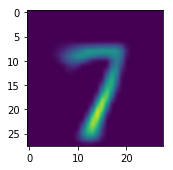

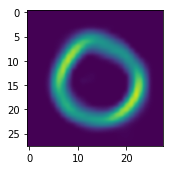

In [376]:
visualizar_imagen(W10[:,3].reshape(28,28))
visualizar_imagen(W10[:,5].reshape(28,28))

A partir de $r=20$ la descomposición por trozos de dígitos comienza a hacerse más notable. Aquí mostramos algunos ejemplos con el dígito cero. 

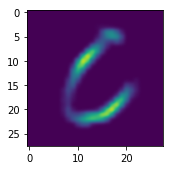

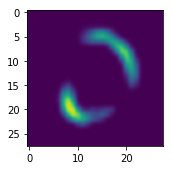

In [377]:
visualizar_imagen(W20[:,1].reshape(28,28))
visualizar_imagen(W20[:,2].reshape(28,28))

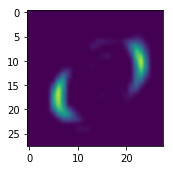

In [380]:
visualizar_imagen(W30[:,26].reshape((28,28)))

Un caso atípico en la descomposición surgio en $r=40$. ¿Por qué habrá descompuesto este tipo de patrón el NNMF? ¿Acaso es esta una estructura fundamental para representar el dígito $7$? No es del todo claro.

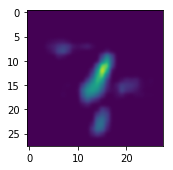

In [384]:
visualizar_imagen(W40[:,14].reshape(28,28))

Descomposición fundamental del dígito $7$ en $r=50$

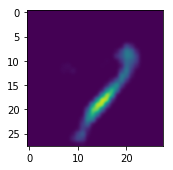

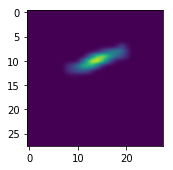

In [375]:
visualizar_imagen(W50[:,1].reshape(28,28))
visualizar_imagen(W50[:,44].reshape(28,28))

**Ejercicio 6.** Compare los resultados obtenidos usando su algoritmo, contra el método de NMF que ya viene implementado en la librería ``scikit-learn`` de Python.

Para implementar este método, basta llamar a la instrucción ``from sklearn.decomposition import NMF`` la cual fue hecha en el principio de este Notebook. Probemos para $r=10$

In [385]:
model = NMF(n_components=10,init ='nndsvd', random_state=None, max_iter =10000)
Wx = model.fit_transform(A)
Hx = model.components_

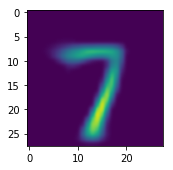

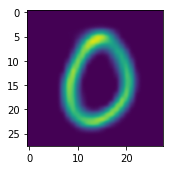

In [387]:
visualizar_imagen(Wx[:,9].reshape(28,28))
visualizar_imagen(Wx[:,4].reshape(28,28))

¡Los resultados son muy similares con los nuestros! A pesar de obtener un alto valor en la función objetivo, el optimizador por descenso de gradiente Nesterov parece estar a la altura en cuanto a calidad de resultados del módulo ``sklearn``. Sin embargo, cuando se habla de tiempo de ejecución, es mejor usar librerias de terceros. 